# Number of Books Read - Simple Linear Regression

A **simple linear regression** is a linear approximation of a casual relationship between two variables - the traget (Dependent/ Y variable) and the feature (Independent/ X variable).

---

### Define the Problem
Can the number of books read per month be predicted based on weekly reading hours?


**The dataset** aims to predict the number of books read per month based on the number of hours spent reading each week. This is a fabricated dataset for a simple linear regression analysis.

**Features:**
- HoursSpentReading: The number of hours spent reading per week, ranging from 0 to 20 hours. This feature captures the amount of time an individual dedicates to reading each week.

**Target:**
- BooksRead: The number of books read per month, with values ranging from 0 to 10 books. This target variable represents the outcome influenced by the amount of weekly reading time.

---



### Summary of Findings

Using a 300-row dataset containing **BooksRead** (target) and **HoursSpentReading per week** (feature), I fit a **simple linear regression model** and conducted all standard diagnostic checks. The OLS results reveal an exceptionally strong linear association between reading time and books read, with a model fit of **R² = 0.967** and an extremely significant overall relationship (**F-statistic ≈ 7035; p < 1×10⁻¹⁷⁸**).

The estimated slope is **≈ 0.24**, meaning each additional hour spent reading per week corresponds, on average, to **about one-quarter of a book more per month**. 

Model assumptions were evaluated on the **training data (80% split)** and showed strong compliance:
- Histograms suggested **residual normality**.
- The residuals-vs-fitted plot showed **no major nonlinearity or heteroscedasticity patterns**.
- **Durbin–Watson ≈ 2.048** indicated essentially **no autocorrelation**, appropriate for cross-sectional data.

Generalization performance was outstanding. With 60 held-out test observations, the model maintained nearly identical accuracy:
- **R² dropped only slightly from 0.967 → 0.961**,
- **RMSE remained stable (0.212 → 0.213)**,
- **MAE remained nearly identical (0.157 → 0.158)**.

Predictions tracked actual book counts closely, with typical deviations of only a few tenths of a book and the largest errors concentrated among very low book-read values (where proportionate differences are naturally higher). Overall, the model showed **excellent stability and minimal overfitting**, supported by near-identical training and testing errors.

Taken together, this single-predictor model is **highly explanatory, stable, and easy to interpret**. 

---

**Pipeline**
1) Load & inspect data
2) Exploratory data analysis (distributions, outliers)
3) Train/Test split (sklearn)
4) Check the regression assumption for linearity
5) Check for multicollinearity (VIF)
6) Check for endogeneity
7) OLS (statsmodels) + Durbin–Watson (autocorrelation check)
8) Normality and homoscedasticity
9) Evaluation on test data
10) Interpretation & recommendations


### Import Libraries

Working in Python 3.9.12 and the Package versions are:
- pandas: 1.5.3
- numpy: 1.23.5
- statsmodels: 0.14.2
- matplotlib: 3.9.2
- seaborn: 0.13.2
- scikit-learn: 1.2.2

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1) Load & Inspect Data

In [2]:
raw_data = pd.read_csv('book_read.csv')
data = raw_data.copy()

display(data.head())
display(data.describe(include='all'))
data.info()

,HoursSpentReading,BooksRead
0,0.000000,0.000000
1,0.021000,0.030000
2,0.748357,0.193161
3,2.744418,0.374320
4,0.100000,0.417181


,HoursSpentReading,BooksRead
count,300.000000,300.000000
mean,9.369195,2.594629
std,4.531502,1.157967
min,0.000000,0.000000
25%,6.125586,1.694887
50%,9.231365,2.582036
75%,12.599622,3.453016
max,20.000000,5.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HoursSpentReading  300 non-null    float64
 1   BooksRead          300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


## 2) Exploratory Data Analysis

From the analysis above, there are no null values and nothing is jumping out as disproportionate.  
Histograms (PDFs) and a condensed boxplot help spot skewness and outliers.

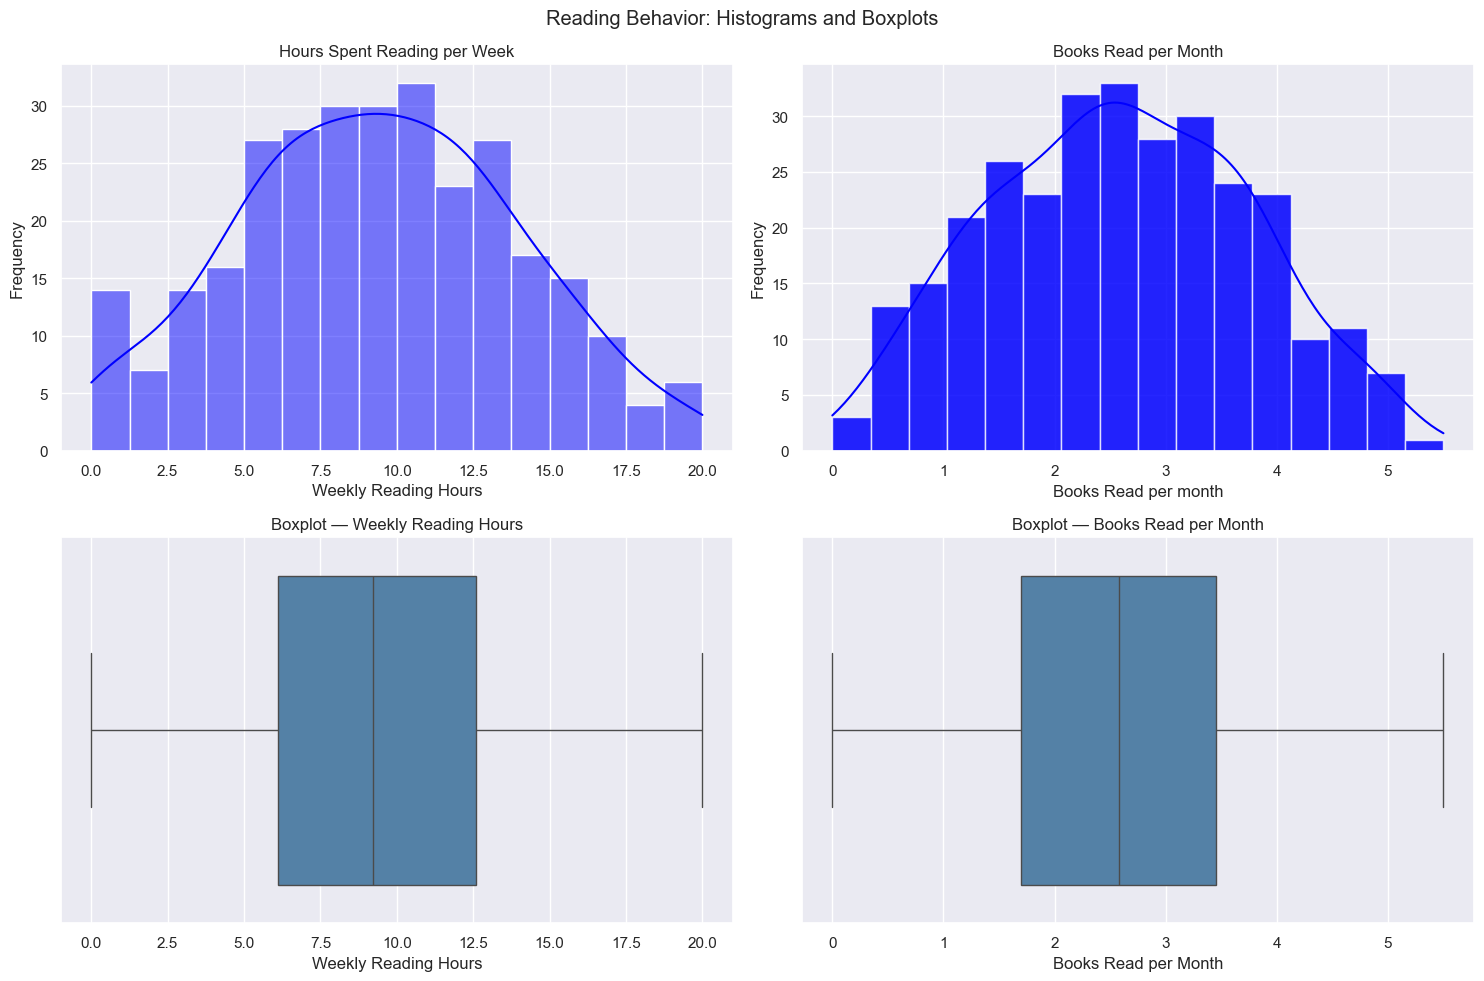

In [3]:
# Create a 2x2 grid of subplots
# sharey=True to use the same y-axis scale
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot each saeborn histogram
sns.histplot(data['HoursSpentReading'], bins=16, kde=True,
             color='blue', ax=axes[0,0])
axes[0,0].set_title('Hours Spent Reading per Week')
axes[0,0].set_xlabel('Weekly Reading Hours')
axes[0,0].set_ylabel('Frequency')

sns.histplot(data['BooksRead'], bins=16, kde=True,
             color='blue', ax=axes[0,1])
axes[0,1].hist(data['BooksRead'], bins = 16, color='blue', alpha=0.7)
axes[0,1].set_title('Books Read per Month')
axes[0,1].set_xlabel('Books Read per month')
axes[0,1].set_ylabel('Frequency')

sns.boxplot(x=data['HoursSpentReading'], color='steelblue', ax=axes[1,0])
axes[1,0].set_title('Boxplot — Weekly Reading Hours')
axes[1,0].set_xlabel('Weekly Reading Hours')

sns.boxplot(x=data['BooksRead'], color='steelblue', ax=axes[1,1])
axes[1,1].set_title('Boxplot — Books Read per Month')
axes[1,1].set_xlabel('Books Read per Month')


# Add a main title
fig.suptitle('Reading Behavior: Histograms and Boxplots')

# Display the plot
plt.tight_layout()
plt.show()

The histograms and boxplots show a normal distribution around both the hours spent reading per week as well as the books read per month

## 3) Train/Test split (sklearn) 
Declare the Inputs and the Targets & then split the data into training data and testing data - the testing data will be used once the model is ready

In [5]:
# Create a copy of the data
regression_data = data.copy()

targets = regression_data['BooksRead']
inputs = regression_data['HoursSpentReading']

# In order to feed x to sklearn, it should be a 2D array (a matrix) - need to reshape it
# This will not be needed when there is more than 1 feature (as the inputs will be a 2D array by default)
# x_matrix = x.values.reshape(300,1)
inputs_matrix = inputs.values.reshape(-1,1)

# Check the shape just in case
print(inputs_matrix.shape)

# Split the variables with an 80-20 split and some random state
x_train, x_test, y_train, y_test = train_test_split(inputs_matrix, targets, test_size=0.2, random_state=365)

(300, 1)


## 4) Check the Regression Assumption for Linearity

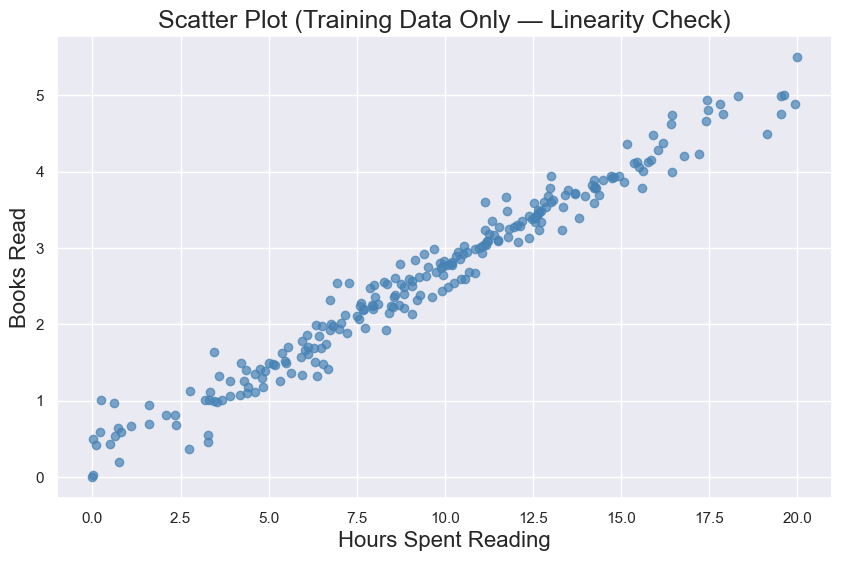

In [6]:
# Scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(x_train, y_train, color='steelblue', alpha=0.7)
plt.xlabel('Hours Spent Reading', fontsize=16)
plt.ylabel('Books Read', fontsize=16)
plt.title('Scatter Plot (Training Data Only — Linearity Check)', fontsize=18)
plt.show()

The scatter plot illustrated Linearity between the independent and dependent variable.

## 5) Check for Multicollinearity (VIF)

As there is only one independent variable (HoursRead) there is no Multicollinearity as that can only arise when 2 or more features have a high correlation.

## 6) Check for Endogeneity
As there is only one X variable and no instruments, the only way to check to endogeneity is conceptually.

1. There is reverse causality  
Do people who read more books cause themselves to read more hours?
Not really, hours > books is a one-direction causal flow.

2. There are omitted variables affecting both:
- reading skill
- motivation
- free time
- age
- access to books

3. Measurement error
- If hours read is self-reported and noisy > bias.

As this is a fabricated dataset, these were not measured & the coefficient might be biased. This cannot be tested without an instrument.

## 7) OLS (statsmodels) + Durbin–Watson (Autocorrelation check)

In [7]:
y = y_train
x1 = x_train
x = sm.add_constant(x1)
model = sm.OLS(y,x).fit()
display(model.summary())

# Calculate the Durbin-Watson statistic on the residuals
dw = durbin_watson(model.resid)
print(f"Durbin–Watson: {dw:.3f} (≈2: none, <2: + autocorr, >2: – autocorr | values below 1 & above 3 cause for alarm use)")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BooksRead   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     7035.
Date:                Thu, 13 Nov 2025   Prob (F-statistic):          9.75e-179
Time:                        13:17:05   Log-Likelihood:                 31.391
No. Observations:                 240   AIC:                            -58.78
Df Residuals:                     238   BIC:                            -51.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2432      0.031      7.759      0.000       0.181       0.305
x1             0.2498      0.003     83.875      0.000       0.244       0.256
==============================================================================
Omnibus:                        5.135   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                6.921
Skew:                           0.085   Prob(JB):                       0.0314
Kurtosis:                       3.814   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Durbin–Watson: 2.048 (≈2: none, <2: + autocorr, >2: – autocorr | values below 1 & above 3 cause for alarm use)


- **R-squared** is 0.967 meaning Hours Spent Reading explains 96.7% of the variability of the number of Books Read.  
- **Prob (F-stat)** is 9.75e-179 meanign the model itself is statistically significant.  
- Hours Spent Reading is has a **p value** < 0.05 meaning there is statistical evidence to suggest that Hours Spent Reading has a significant effect on the Number of Books read, at a 95% confidence level.  

- The Durbin-Watson statistic ranges from 0 to 4: 2 indicates no autocorrelation while values below 1 and above 3 cause for alarm
- Results 2: Indicates no autocorrelation.
- Results 0 to <2: Indicates positive autocorrelation.
- Results >2 to 4: Indicates negative autocorrelation.

The Results are 2.048 meaning there is no autocorrelation.  

This is a reliable model!

## 8) Normality and Homoscedasticity (sklearn)

Training Performance:


R²      0.967
RMSE    0.212
MAE     0.157
dtype: float64

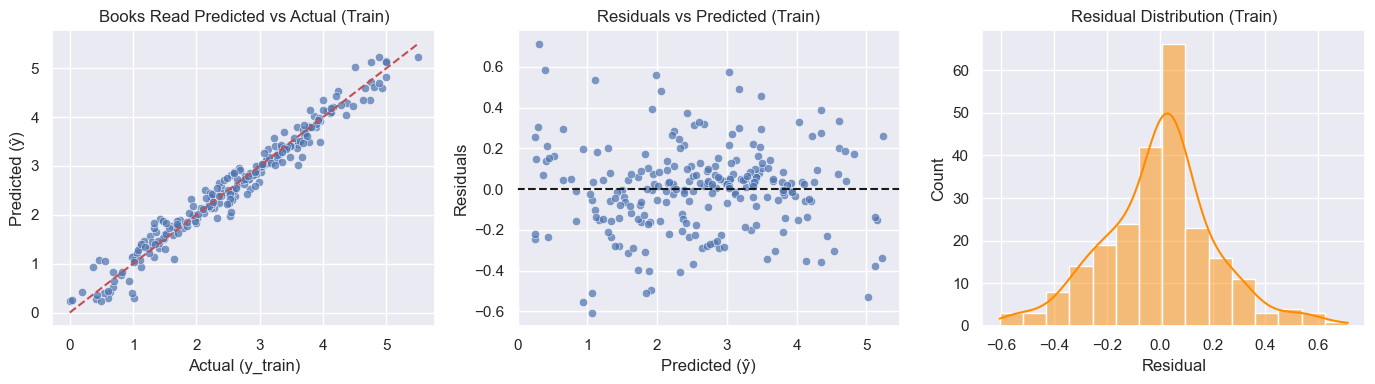

In [8]:
# Initialize and fit model on TRAINING data
reg = LinearRegression()
reg.fit(x_train, y_train)

# Predict on training data
y_hat_train = reg.predict(x_train)

# Evaluate training performance
def model_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return pd.Series({'R²': r2, 'RMSE': rmse, 'MAE': mae})

train_metrics = model_metrics(y_train, y_hat_train)

print("Training Performance:")
display(train_metrics.round(3))


# Residual diagnostics (test)
residuals = y_train - y_hat_train

fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.scatterplot(x=y_train, y=y_hat_train, ax=axes[0], alpha=0.7)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
axes[0].set_title('Books Read Predicted vs Actual (Train)')
axes[0].set_xlabel('Actual (y_train)')
axes[0].set_ylabel('Predicted (ŷ)')

sns.scatterplot(x=y_hat_train, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(0, color='k', ls='--')
axes[1].set_title('Residuals vs Predicted (Train)')
axes[1].set_xlabel('Predicted (ŷ)')
axes[1].set_ylabel('Residuals')

sns.histplot(residuals, bins=15, kde=True, ax=axes[2], color='darkorange')
axes[2].set_title('Residual Distribution (Train)')
axes[2].set_xlabel('Residual')

plt.tight_layout()
plt.show()


## 9) Evaluation on Test Data

Model Evaluation Summary (Train vs Test):


,Training Set,Testing Set
R²,0.967,0.961
RMSE,0.212,0.213
MAE,0.157,0.158


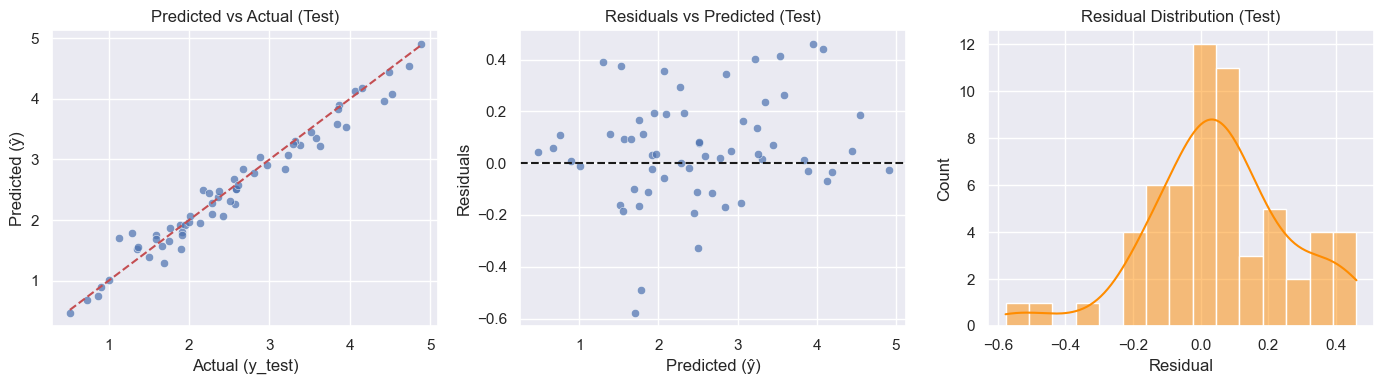

In [9]:
# Predict on TEST data
y_hat_test  = reg.predict(x_test)

# Evaluate testing performance
test_metrics  = model_metrics(y_test,  y_hat_test)

# Combine results
summary = pd.concat([train_metrics, test_metrics], axis=1)
summary.columns = ['Training Set', 'Testing Set']
print("Model Evaluation Summary (Train vs Test):")
display(summary.round(3))


# Residual diagnostics (test)
residuals = y_test - y_hat_test

# (1) Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.scatterplot(x=y_test, y=y_hat_test, ax=axes[0], alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title('Predicted vs Actual (Test)')
axes[0].set_xlabel('Actual (y_test)')
axes[0].set_ylabel('Predicted (ŷ)')

# (2) Residuals vs Predicted
sns.scatterplot(x=y_hat_test, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(0, color='k', ls='--')
axes[1].set_title('Residuals vs Predicted (Test)')
axes[1].set_xlabel('Predicted (ŷ)')
axes[1].set_ylabel('Residuals')

# (3) Residual Distribution
sns.histplot(residuals, bins=15, kde=True, ax=axes[2], color='darkorange')
axes[2].set_title('Residual Distribution (Test)')
axes[2].set_xlabel('Residual')

plt.tight_layout()
plt.show()

For the most part, the test prediction are looking quite inline with the test targets. The bigger discrepancies are between 1 and 2.

In [10]:
# Create a DataFrame to manually check the predictions
df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])

# Reset the index as the old indexes are preserved 
y_test = y_test.reset_index(drop=True)

# Add a 'Target' column with the appropriate values
df_pf['Target'] = y_test

# Manually create the Residuals
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

# Manually create the absolute difference in %
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.head(15)

# Display the result with only 2 digits after the dot
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
43,2.29,2.29,0.00,0.04
47,3.83,3.85,0.01,0.35
35,3.31,3.32,0.01,0.43
4,4.91,4.88,-0.03,0.54
26,2.78,2.81,0.02,0.77
6,3.89,3.86,-0.03,0.77
45,0.89,0.90,0.01,0.82
56,4.19,4.15,-0.04,0.85
9,2.38,2.36,-0.02,0.86
58,2.59,2.61,0.03,1.07


## 10) Interpretation & Recommendations

**Model Evaluation Summary Interpretation**

| Metric | Training | Testing | Interpretation |
|:-------|:----------|:---------|:----------------|
| **R²** | 0.967 | 0.961 | The model explains **96.7%** of the variance in the number of books read on the training data and **96.1%** on unseen data. This indicates an **extremely strong linear relationship** between hours spent reading and books read, with almost no loss in performance on the test set. |
| **RMSE** | 0.212 | 0.213 | The root-mean-squared error is nearly identical between training and testing, showing that typical prediction errors are small and very consistent across seen and unseen data. This suggests the model is not overfitting. |
| **MAE** | 0.157 | 0.158 | On average, predictions differ from the actual number of books read by about **0.16 units** on both training and testing sets. The near equality of MAE across sets reinforces that the model’s errors are **stable and well-behaved.** |

**Overall Interpretation**
This simple OLS regression model (predicting **BooksRead** from **HoursSpentReading**) shows:
- Very high explanatory power (R² ≈ 0.96 on both train and test).
- Minimal generalization gap between training and testing metrics → little to no overfitting.
- Error metrics (RMSE/MAE) that are almost identical on train vs test → strong evidence that the relationship it learned generalizes well.

> In plain language:
> As study hours increase, the model captures the corresponding increase in books read very accurately, and it performs just as well on new data as on the data it was trained on.

**Recommendations**
To further explore or extend this analysis:
1. **Consider adding more predictors (if available)**
- For example: reading skill, pages per book, access to books, genre preference, or free time.
- This could help explain any remaining unexplained variance.
2. **Use the model for prediction & “what-if” scenarios**
- Estimate how many books someone is likely to read if they increase their reading time by 1–2 hours per week.
- Compare predicted vs actual values for specific observations of interest.

> **In summary:**  
> The model does an **excellent job** predicting the number of books read from hours spent reading, with *strong generalization* and **very small, stable errors** across both training and testing data.